In [3]:
%matplotlib inline

# Packages
import os, glob, scipy, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Project directory
base_dir = os.path.realpath('..')
print(base_dir)

# Project-specific functions
funDir = os.path.join(base_dir,'Code/Functions')
print(funDir)
sys.path.append(funDir)
import choiceModels, costFunctions, penalizedModelFit, simulateModel

# General-use python functions
dbPath = '/'.join(base_dir.split('/')[0:4])
sys.path.append('%s/Python'%dbPath)
import FigureTools

/Users/jeroen/Dropbox (Brown)/PhD/0. Working folder/HMTG_followUp_final/ShareDataCode
/Users/jeroen/Dropbox (Brown)/PhD/0. Working folder/HMTG_followUp_final/ShareDataCode/Code/Functions


## Load data

In [5]:
results_study1 = pd.read_csv(os.path.join(base_dir,'Data/Study1/ComputationalModel/Results_study1.csv'),
                         index_col=0)
results_study1.loc[results_study1['baseMult']==4,'set'] = 'Study 1, x2-x4-x6'
results_study1.loc[results_study1['baseMult']==6,'set'] = 'Study 1, x4-x6-x8'
results_study2 = pd.read_csv(os.path.join(base_dir,'Data/Study2/ComputationalModel/Results_study2.csv'),
                         index_col=0)
results_study2['set'] = 'Study 2'
results_all = results_study1[['set','sub','model','SSE','AIC','BIC']].append(
    results_study2[['set','sub','model','SSE','AIC','BIC']])
results_all.head()

,set,sub,model,SSE,AIC,BIC
0,"Study 1, x2-x4-x6",1,GR,7533.0,349.229109,349.229109
1,"Study 1, x2-x4-x6",1,GA,756.0,176.595411,178.926144
2,"Study 1, x2-x4-x6",1,GA_ppSOE,1348.0,220.548940,222.879674
3,"Study 1, x2-x4-x6",1,IA,169.0,62.736568,65.067302
4,"Study 1, x2-x4-x6",1,MP,168.0,64.285529,68.946995


#### Exclude near perfect fit and other exclusions

In [7]:
excludeSub = np.array(results_all.loc[results_all['SSE']<10,'sub'].unique())
excludeSub
exclude1 = np.array(pd.read_csv(os.path.join(base_dir,'Data/Study1/HMTG/exclude.csv'),index_col=None,header=None).T)[0]
excludeSub = np.hstack([excludeSub,exclude1])
exclude2 = np.array(pd.read_csv(os.path.join(base_dir,'Data/Study2/HMTG/exclude.csv'),index_col=0,header=0).T)[0]
excludeSub = np.hstack([excludeSub,exclude2])
excludeSub = np.unique(excludeSub)
excludeSub

array([  2,   5,   7,  43,  56,  59,  83,  91,  95, 102, 159, 161, 182,
       203])

In [8]:
results_all = results_all.loc[~results_all['sub'].isin(excludeSub)]
results_all.head()

,set,sub,model,SSE,AIC,BIC
0,"Study 1, x2-x4-x6",1,GR,7533.0,349.229109,349.229109
1,"Study 1, x2-x4-x6",1,GA,756.0,176.595411,178.926144
2,"Study 1, x2-x4-x6",1,GA_ppSOE,1348.0,220.548940,222.879674
3,"Study 1, x2-x4-x6",1,IA,169.0,62.736568,65.067302
4,"Study 1, x2-x4-x6",1,MP,168.0,64.285529,68.946995


## Quick check

In [9]:
for dataset in np.unique(results_all['set']):
    for model in ['GA','IA','MP_ppSOE']:
        mean_AIC = results_all.loc[(results_all['set']==dataset) & (results_all['model']==model),'AIC'].mean()
        print('%s, model %s: mean AIC = %.2f'%(dataset,model,mean_AIC))
    print('')

Study 1, x2-x4-x6, model GA: mean AIC = 188.36
Study 1, x2-x4-x6, model IA: mean AIC = 121.74
Study 1, x2-x4-x6, model MP_ppSOE: mean AIC = 112.72

Study 1, x4-x6-x8, model GA: mean AIC = 208.56
Study 1, x4-x6-x8, model IA: mean AIC = 145.79
Study 1, x4-x6-x8, model MP_ppSOE: mean AIC = 140.66

Study 2, model GA: mean AIC = 166.99
Study 2, model IA: mean AIC = 126.26
Study 2, model MP_ppSOE: mean AIC = 111.43



In [10]:
for dataset in np.unique(results_all['set']):
    dat_IA = results_all.loc[(results_all['set']==dataset) & (results_all['model']=='IA'),'AIC']
    dat_MP_ppSOE = results_all.loc[(results_all['set']==dataset) & (results_all['model']=='MP_ppSOE'),'AIC']
    print(scipy.stats.ttest_rel(dat_IA,dat_MP_ppSOE))
    print('')

Ttest_relResult(statistic=2.6456910922749097, pvalue=0.009572267417278029)

Ttest_relResult(statistic=1.3088901986547687, pvalue=0.19379662927047084)

Ttest_relResult(statistic=3.308567994275955, pvalue=0.0017069091133856554)



## Plot model fits

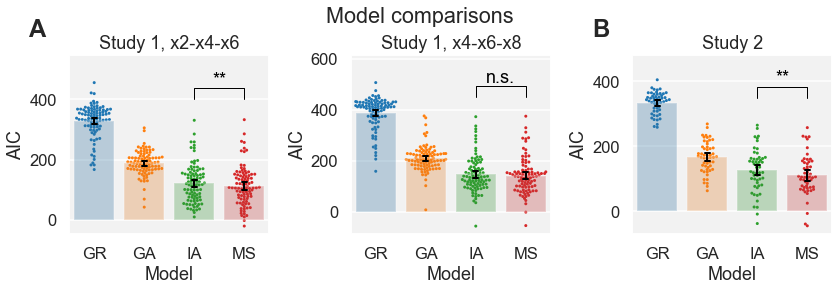

In [21]:
# Design
sns.set_style('darkgrid', {"axes.facecolor": ".95"})
sns.set_palette('tab10')
sns.set_context('talk')
# Data
measures = ['AIC']
measureNames = ['AIC']
models = ['GR','GA','IA','MP_ppSOE']
modelNames = ['GR','GA','IA','MS']
fig,axes = plt.subplots(nrows = len(measures), ncols = 3,figsize=[12,4],sharey=False)
stats = pd.DataFrame(columns=['set','measure','n','t','p'])
ystarts = [400,450,350]
for m,measure in enumerate(measures):
    for i,dataset in enumerate(np.unique(results_all['set'])):
        ax = axes[i]
        sns.barplot(data=results_all.loc[(results_all['set']==dataset) & (results_all['model'].isin(models))],
                    x='model',y=measure,alpha=.3,errwidth=0,ax=ax)
        sns.swarmplot(data=results_all.loc[(results_all['set']==dataset) & (results_all['model'].isin(models))],
                    x='model',y=measure,alpha=1,s=3,ax=ax,zorder = 1)
        sns.barplot(data=results_all.loc[(results_all['set']==dataset) & (results_all['model'].isin(models))],
                    x='model',y=measure,errwidth=2,capsize=0.1,errcolor='k',alpha=0,ax=ax,zorder = 10)
        ax.set(title='%s'%(dataset),
                  xlabel='Model',ylabel=measureNames[m],xticklabels=modelNames)
        IA = results_all.loc[(results_all['set']==dataset) & (results_all['model']=='IA'),measure]
        MP = results_all.loc[(results_all['set']==dataset) & (results_all['model']=='MP_ppSOE'),measure]
        out = scipy.stats.ttest_rel(IA,MP,nan_policy='omit')
        stats = stats.append(pd.DataFrame([[dataset,measure,len(IA),out[0],out[1]]],columns=stats.columns)).reset_index(drop=True)
        ystart = ystarts[i]
        FigureTools.add_sig_markers(ax, relationships = [[2,3,out[1]]], ystart = ystart)#, markerType = 'pval')
plt.suptitle('Model comparisons',y=1.03)
plt.tight_layout()
FigureTools.add_subplot_letter(axes[0])
FigureTools.add_subplot_letter(axes[2],'B')
plt.savefig(base_dir + '/Results/Figure2.pdf',bbox_inches='tight')

In [22]:
stats

,set,measure,n,t,p
0,"Study 1, x2-x4-x6",AIC,94,2.645691,0.009572
1,"Study 1, x4-x6-x8",AIC,94,1.308890,0.193797
2,Study 2,AIC,53,3.308568,0.001707


#### Test mean AIC/BIC across contexts

In [24]:
measure = 'AIC'
sets = ['Study 1, x2-x4-x6','Study 1, x4-x6-x8']
IA = results_all.loc[(results_all['set'].isin(sets)) & (results_all['model']=='IA'),
                     ['sub','set',measure]].groupby('sub').mean()
MP = results_all.loc[(results_all['set'].isin(sets)) & (results_all['model']=='MP_ppSOE'),
                     ['sub','set',measure]].groupby('sub').mean()
# IA
out = scipy.stats.ttest_rel(IA,MP,nan_policy='omit')
print(len(IA))
print(out)

94
Ttest_relResult(statistic=array([2.06619819]), pvalue=array([0.04159056]))


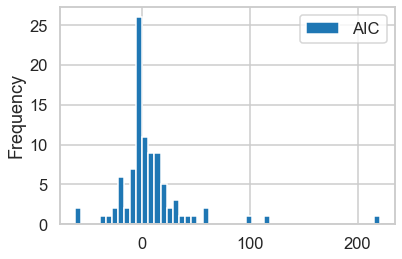

In [25]:
sns.set_style('whitegrid');
(IA-MP).plot(kind='hist',bins=50)